3個變量的VARMA(2,1)模型

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import kpss, adfuller, ccf, ccovf
from statsmodels.iolib.smpickle import load_pickle
from collections import deque

In [2]:
horizon = pd.read_csv(".\\data\\horizon_3multivariate_final.csv", encoding="utf-8")
horizon_diff = horizon.diff().dropna()
horizon.head()

,CPU Overall Power Consumption,GPU Power,FPS
0,99.895,305.353,113
1,104.135,341.418,146
2,107.012,345.209,147
3,105.918,342.610,150
4,103.853,345.456,152


## VARMA DIFF

In [3]:
horizon_diff_train = horizon_diff[:-300]
horizon_diff_test = horizon_diff[-300:]

In [4]:
def find_VARMA_order_pq(pq_sum=3):
    pq_pair = [(p, pq_sum-p) for p in range(pq_sum+1)]
    fps_model_dict = {}
    fps_model_deque = deque([], maxlen=1)
    for (p, q) in pq_pair:
        model_result = VARMAX(horizon_diff_train, order=(p, q)).fit()
        fps_model_dict[f"result_{p}{q}"] = model_result
        if p==0:
            fps_model_deque.append(model_result)
            continue
        if fps_model_deque[0].aic > model_result.aic:
            fps_model_deque.append(model_result)
    return fps_model_dict, fps_model_deque

In [5]:
# fps_model_dict, fps_model_deque = find_VARMA_order_pq()
# for (k, v) in fps_model_dict.items():
#     fps_model_dict[k].save(f".\\weights\\VARMA 3\\VARMA_{k}.pickle")

In [6]:
# for (k, v) in fps_model_dict.items():
#     print(k, ":", v.hqic)

In [7]:
# model_result61 = VARMAX(horizon_diff_train, order=(6, 1)).fit()
# model_result61.save(f".\\weights\\VARMA DIFF 3\\VARMA_result_61.pickle")

In [8]:
VARMA_fps_result_61 = load_pickle(".\\weights\\VARMA DIFF 3\\VARMA_result_61.pickle")
# VARMA_fps_result_61.summary()

In [9]:
# VARMA_fps_result_21 = load_pickle(".\\weights\\VARMA 3\\VARMA_result_21.pickle")
# VARMA_fps_result_21.summary()

In [10]:
VARMA_fps_result_61.impulse_responses(impulse=2, orthogonalized=False, steps=10)

,CPU Overall Power Consumption,GPU Power,FPS
0,0.000000,0.000000,1.000000
1,-0.067251,0.068050,-0.336938
2,0.018878,0.042359,-0.232973
3,0.032333,-0.057683,-0.085774
4,-0.010160,-0.063024,-0.017883
5,-0.000120,-0.029520,-0.046511
6,0.018901,-0.021625,0.001200
7,0.001739,0.012445,-0.014533
8,-0.003039,0.021038,-0.017177
9,-0.000608,0.004202,-0.010938


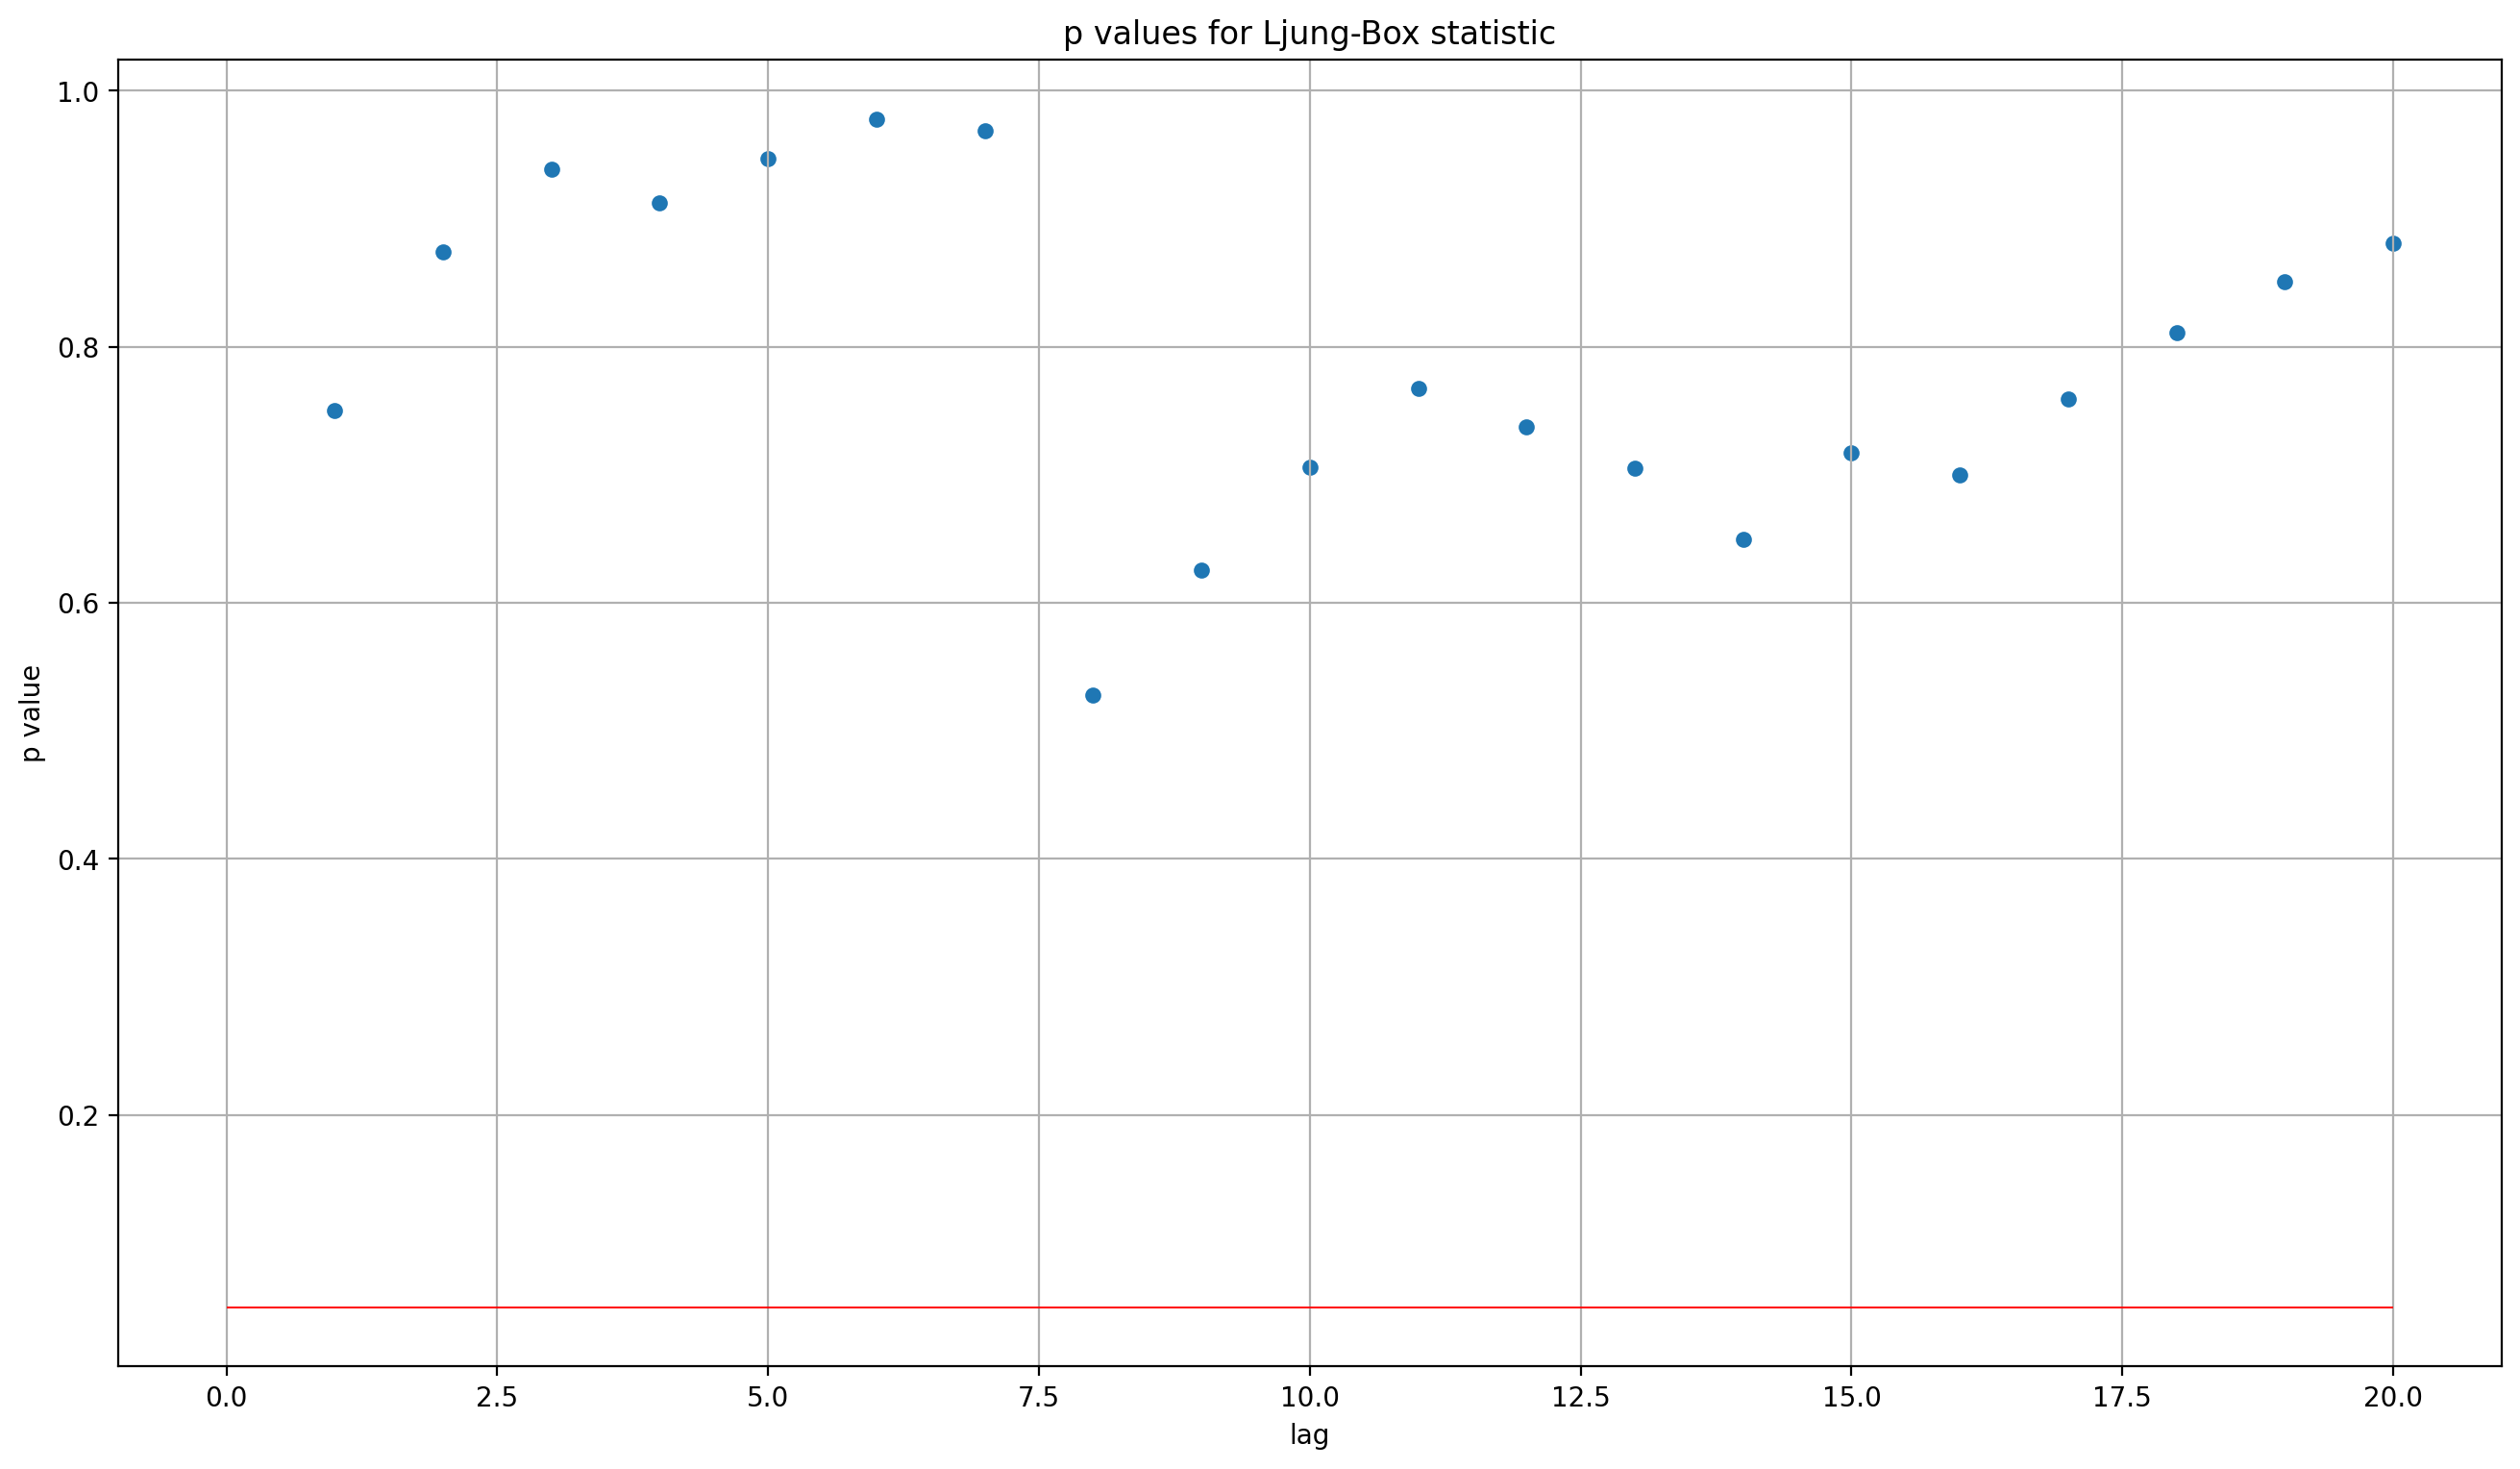

In [11]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(list(range(1,21)), VARMA_fps_result_61.test_serial_correlation(method="ljungbox", lags=20)[2, 1, :], s=25)
plt.hlines(y=[0.05], xmin=0, xmax=20, colors="r", linewidths=0.7)
# plt.axis([0, 20, 0, 1])
plt.title("p values for Ljung-Box statistic")
plt.xlabel("lag")
plt.ylabel("p value")
plt.grid()
plt.show()

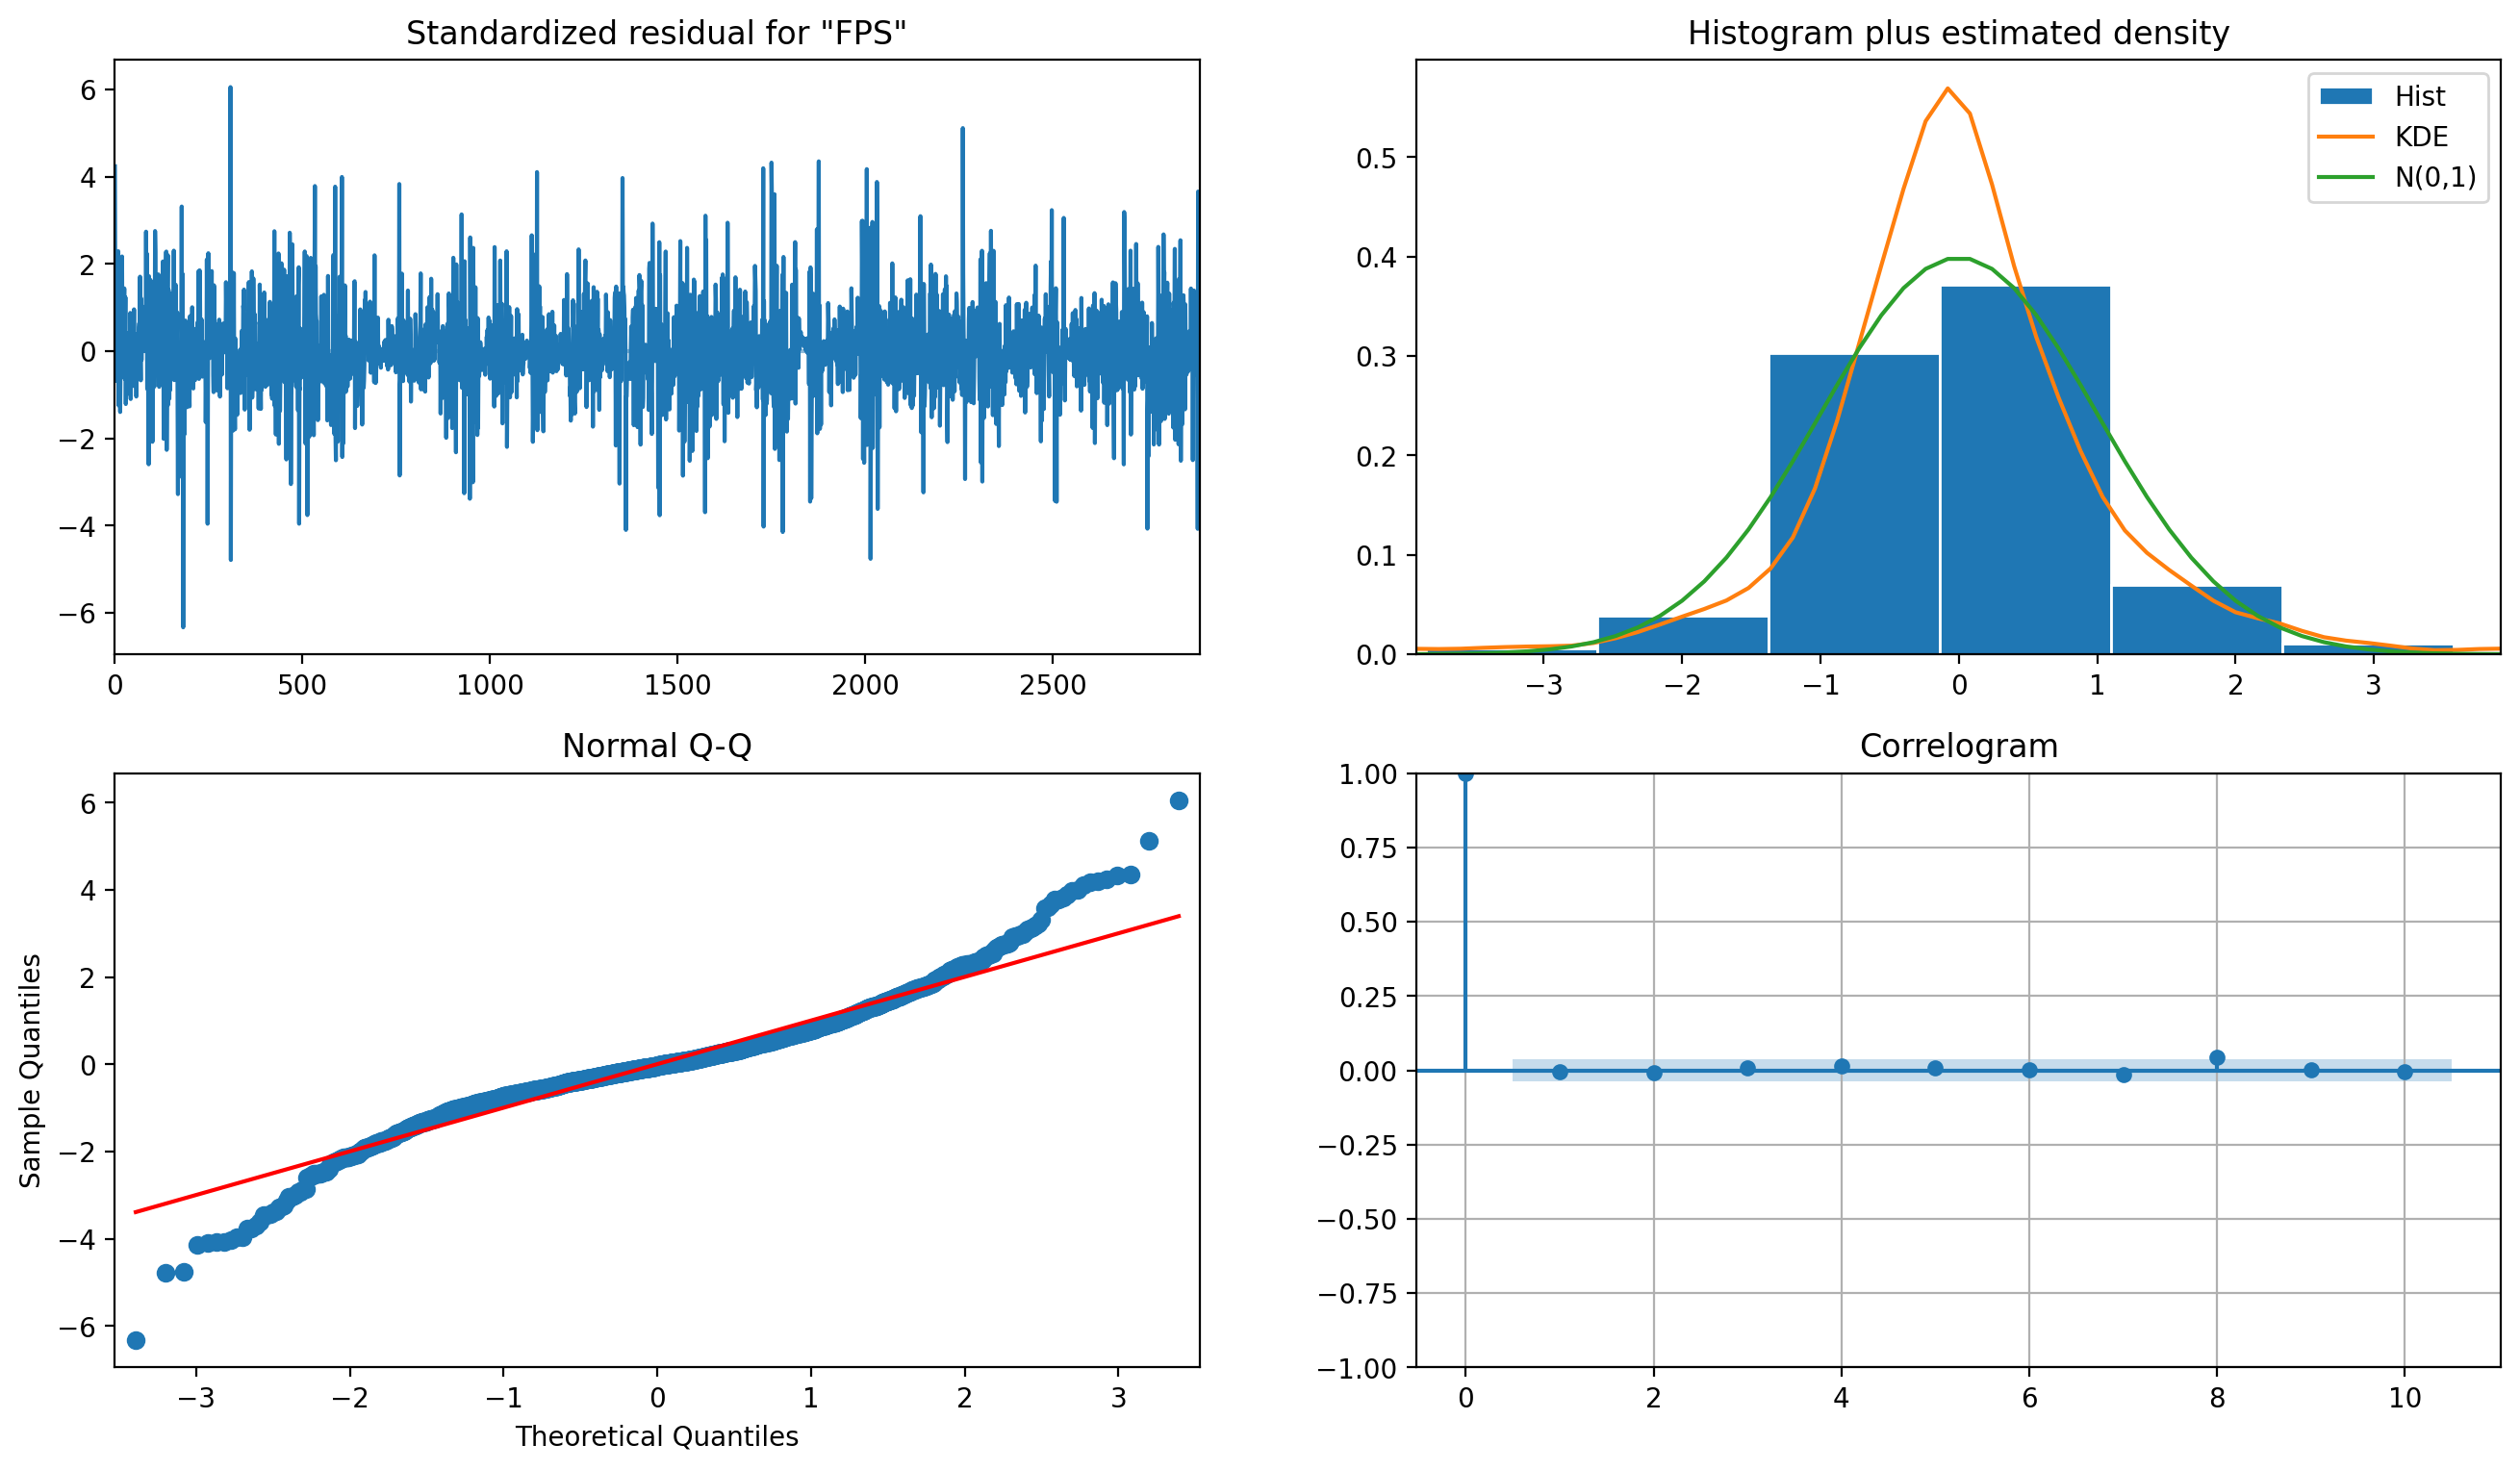

In [12]:
VARMA_fps_result_61.plot_diagnostics(variable=2, fig=plt.figure(figsize=(16,9), dpi=200))
plt.grid()
plt.show()

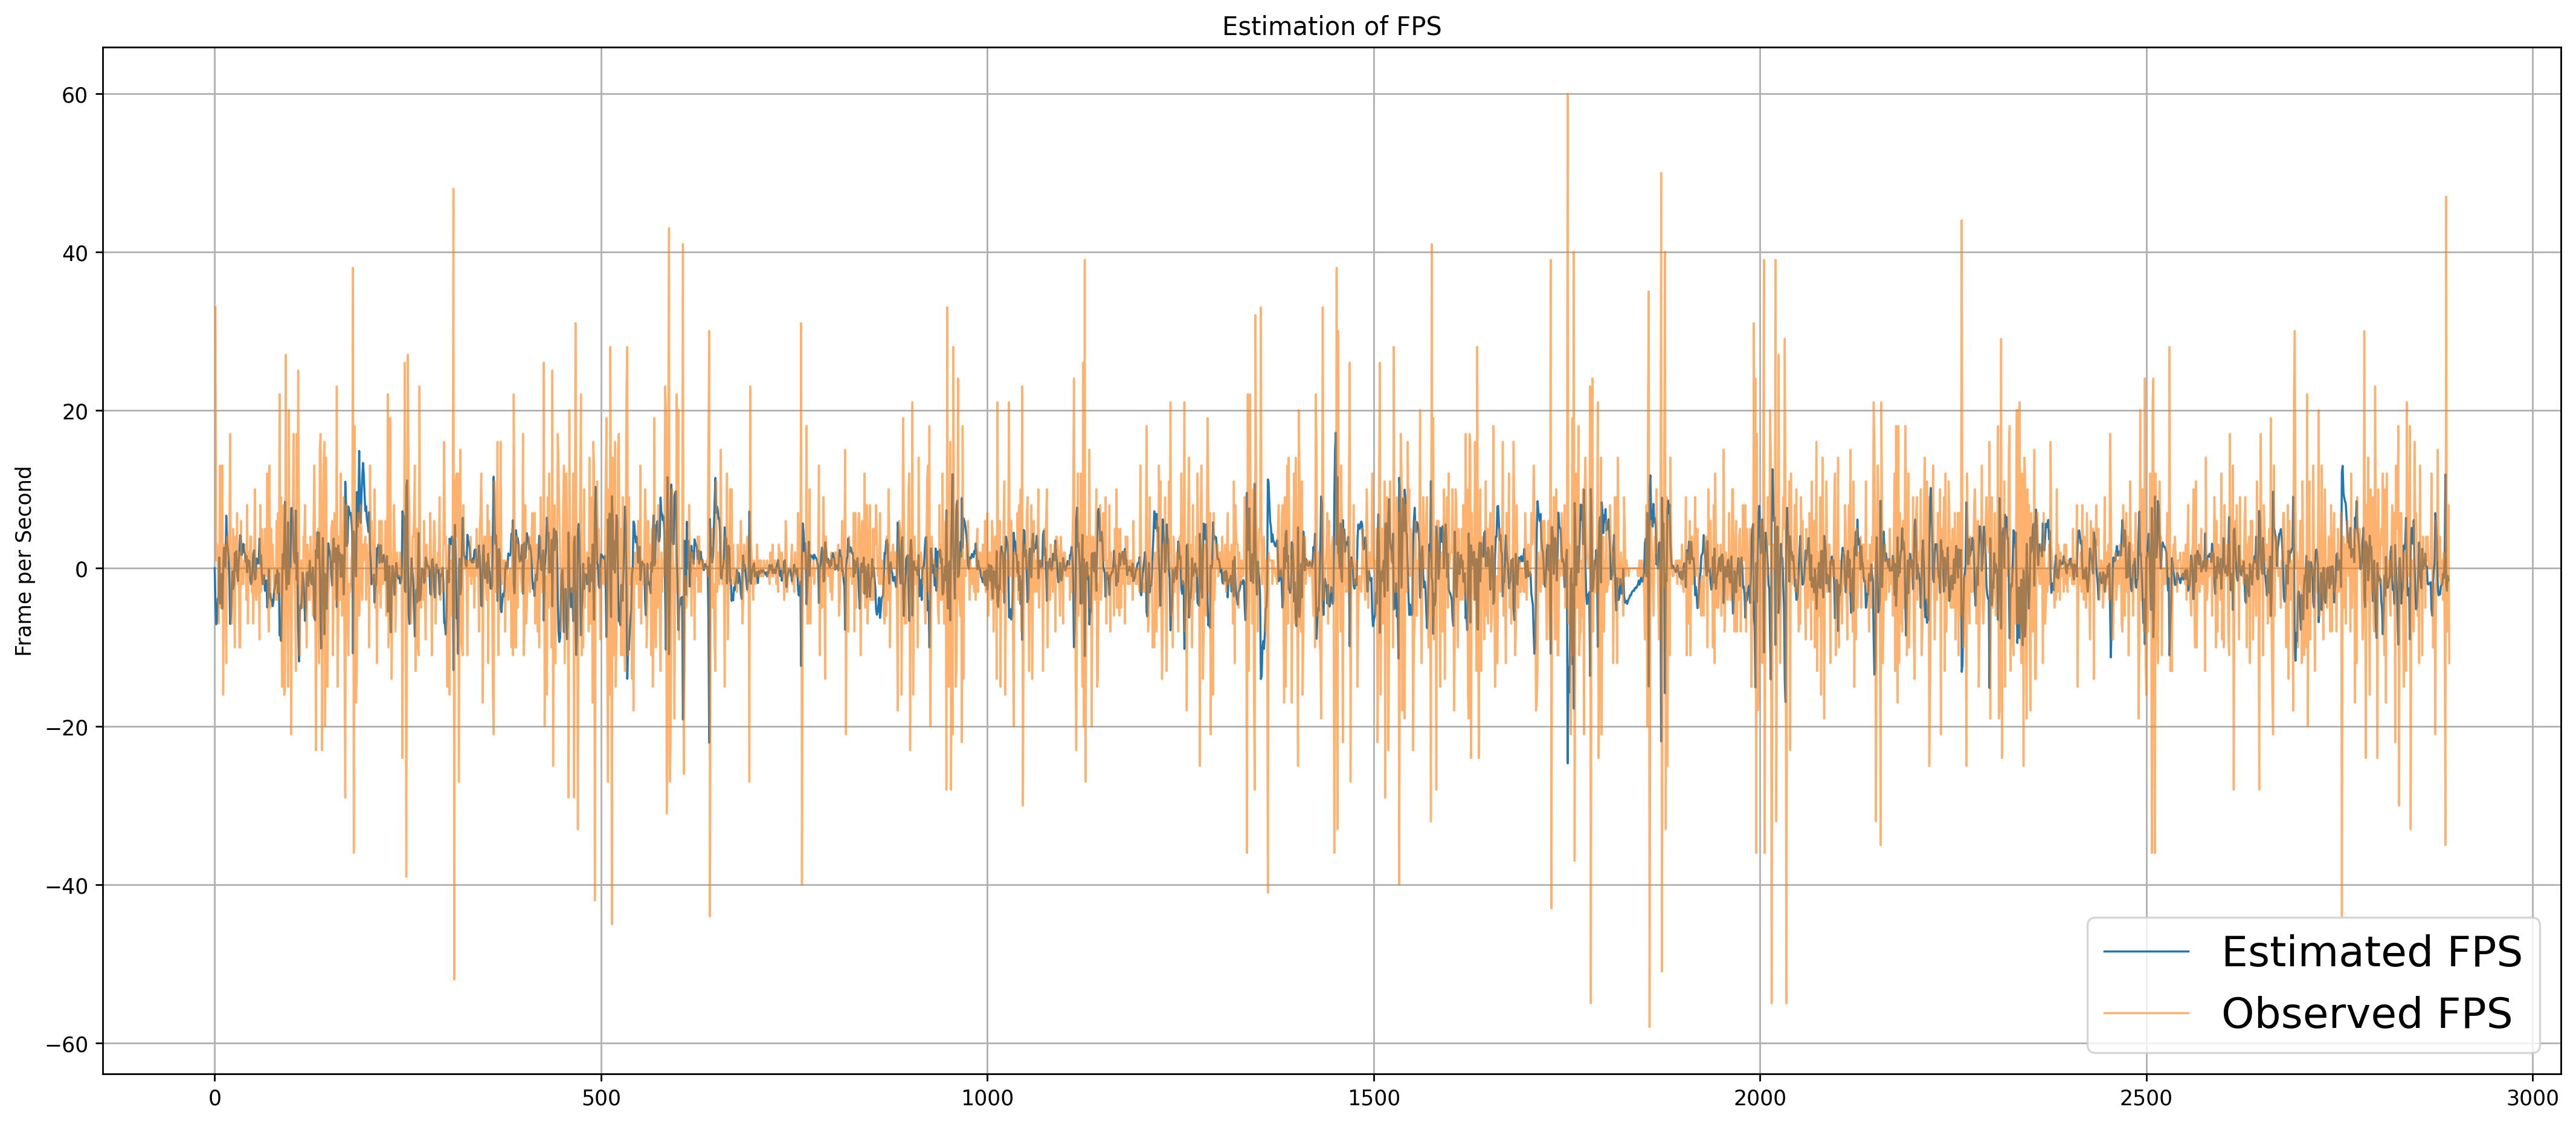

In [13]:
hat_FPS = VARMA_fps_result_61.predict().to_numpy()[:, 2]
plt.figure(figsize=(21, 9), dpi=250)
ts1, = plt.plot(hat_FPS, linewidth=1, label="Estimated FPS", c='tab:blue')
ts2, = plt.plot(horizon_diff_train["FPS"], linewidth=1, label="Observed FPS", c='tab:orange', alpha=0.6)
plt.legend(handles=[ts1, ts2], fontsize=20)
plt.title("Estimation of FPS")
plt.ylabel("Frame per Second")
plt.grid()
plt.show()

In [14]:
varmax_forecasting = VARMA_fps_result_61.get_forecast(steps=300)

e:\Master\Time Series\TimeSeries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


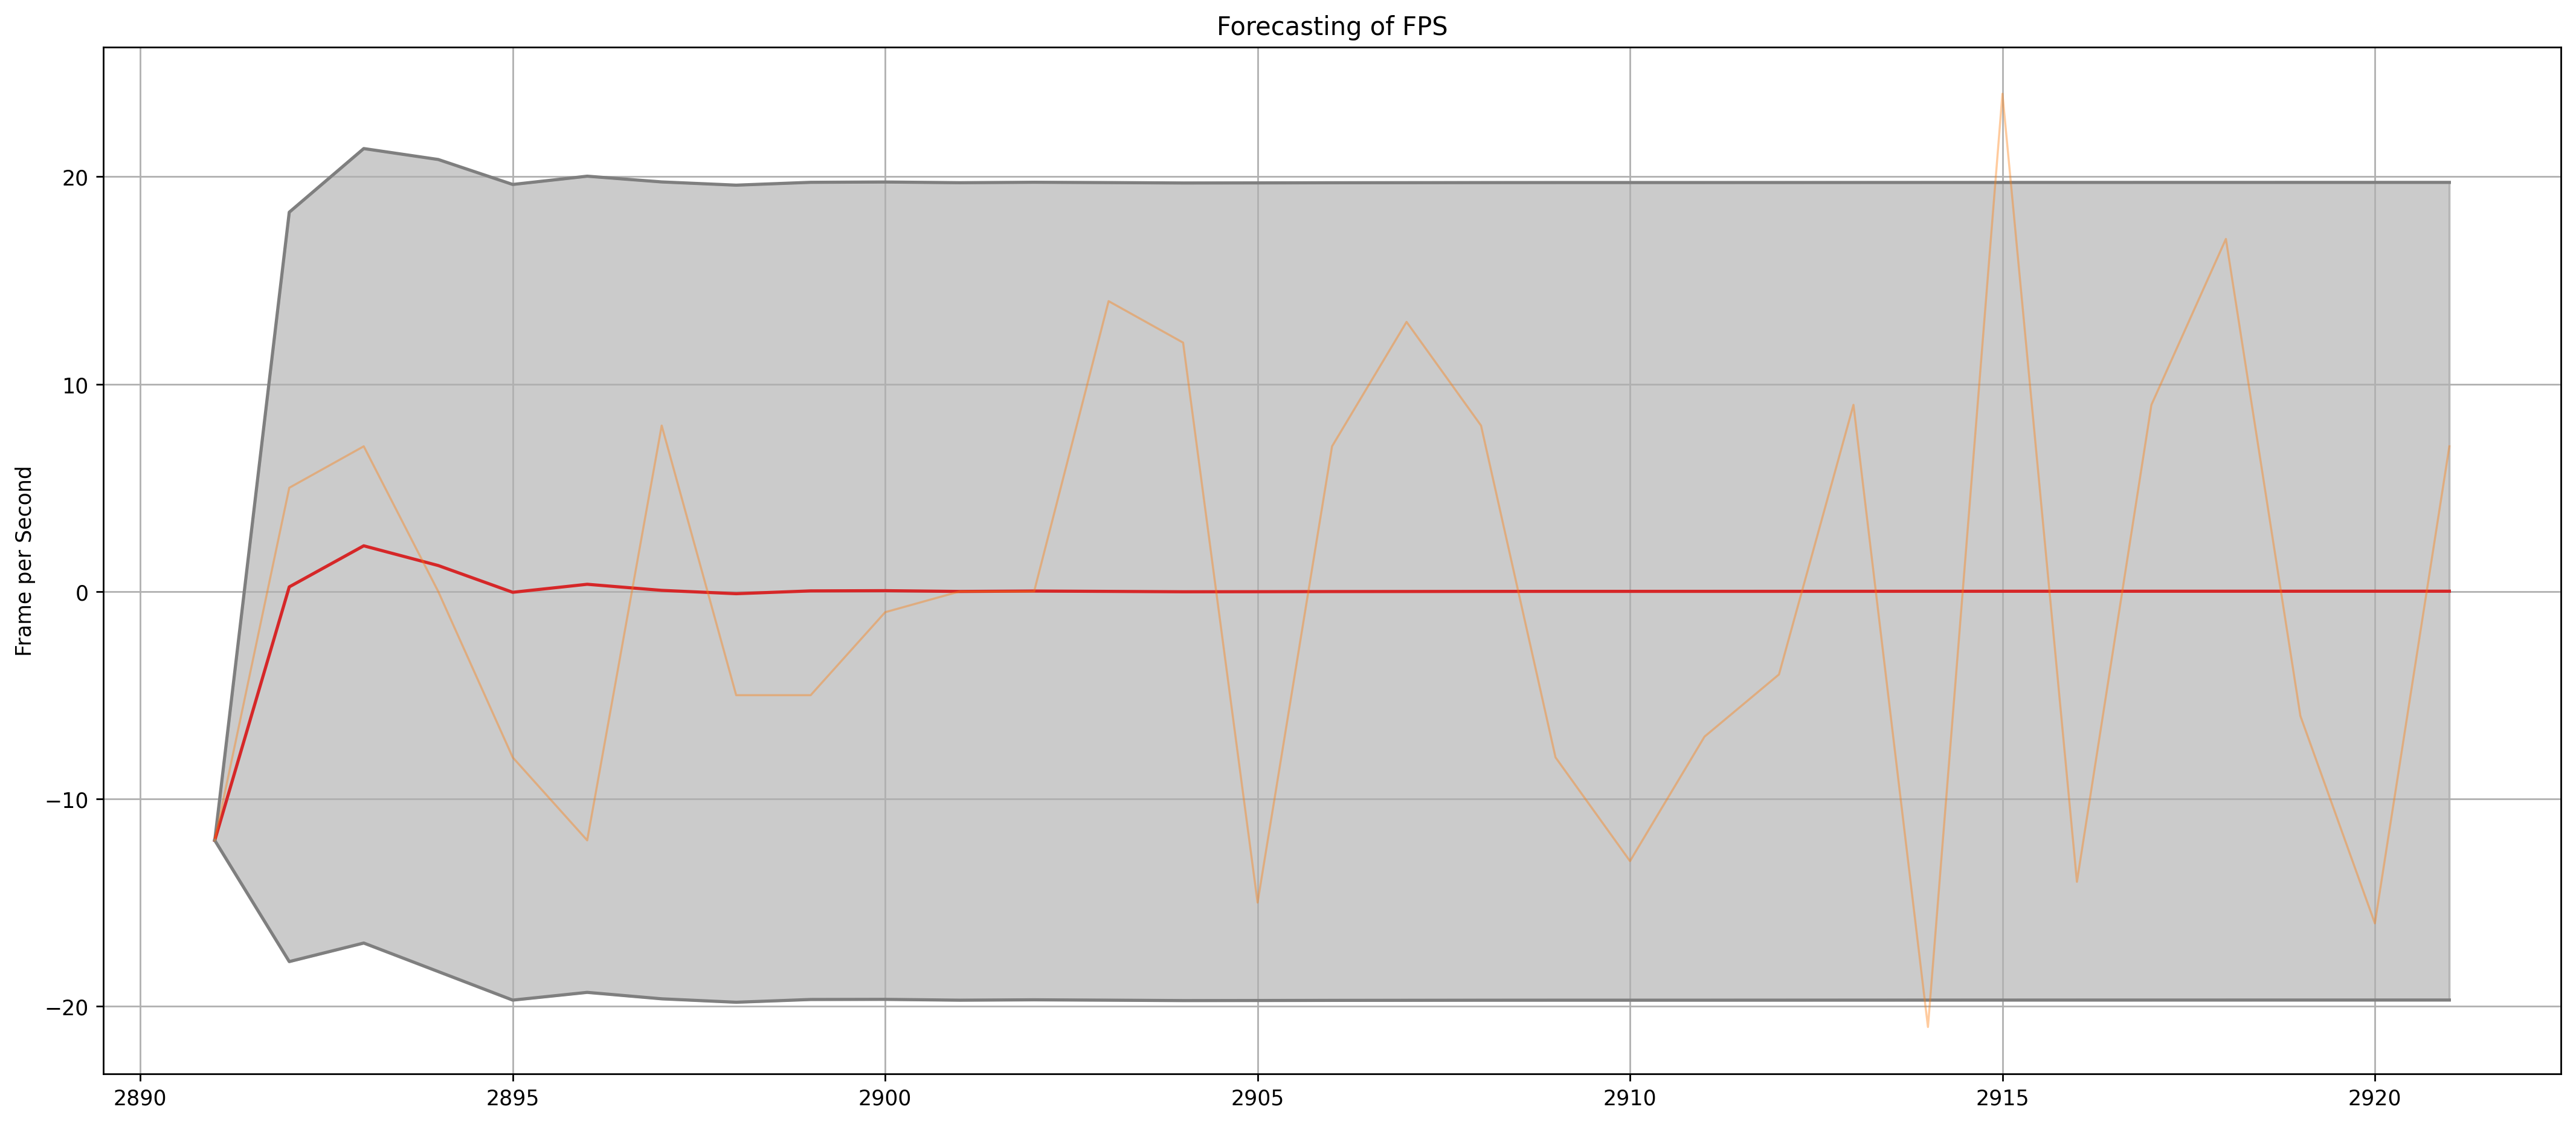

In [15]:
plt.figure(figsize=(21, 9), dpi=250)
# plt.plot(list(range(2892)), horizon_diff_train["FPS"], linewidth=1, label="Observed FPS", c='tab:blue')
# plt.plot(list(range(2891, 3192)), upper:=pd.concat([horizon_diff_train["FPS"], varmax_forecasting.conf_int()["upper FPS"]]).iloc[2891:], c='tab:gray')
# plt.plot(list(range(2891, 3192)), pd.concat([horizon_diff_train["FPS"], varmax_forecasting.predicted_mean["FPS"]]).iloc[2891:], c='tab:red')
# plt.plot(list(range(2891, 3192)), lower:=pd.concat([horizon_diff_train["FPS"], varmax_forecasting.conf_int()["lower FPS"]]).iloc[2891:], c='tab:gray')
# plt.fill_between(list(range(2891, 3192)), upper, lower, color="tab:gray", alpha=0.4)
plt.plot(list(range(2891, 2922)), upper:=pd.concat([horizon_diff_train["FPS"], varmax_forecasting.conf_int()["upper FPS"]]).iloc[2891:2922], c='tab:gray')
plt.plot(list(range(2891, 2922)), pd.concat([horizon_diff_train["FPS"], varmax_forecasting.predicted_mean["FPS"]]).iloc[2891:2922], c='tab:red')
plt.plot(list(range(2891, 2922)), lower:=pd.concat([horizon_diff_train["FPS"], varmax_forecasting.conf_int()["lower FPS"]]).iloc[2891:2922], c='tab:gray')
plt.fill_between(list(range(2891, 2922)), upper, lower, color="tab:gray", alpha=0.4)
plt.plot(
    list(range(2891, 2922)), np.hstack((horizon_diff_train["FPS"].to_numpy()[-1], horizon_diff_test["FPS"].to_numpy()[:30])),
    linewidth=1, c='tab:orange', alpha=0.4
)
plt.title("Forecasting of FPS")
plt.ylabel("Frame per Second")
plt.grid()
plt.show()

In [16]:
# np.save(".\\forecasting result\\varma_61.npy", varmax_forecasting.predicted_mean["FPS"].to_numpy())

## VARMA

In [17]:
horizon_train = horizon[:-10]
horizon_test = horizon[-10:]

In [18]:
# model_result61 = VARMAX(horizon_train, order=(6, 1)).fit()
# model_result61.save(f".\\weights\\VARMA 3\\VARMA_result_61.pickle")

e:\Master\Time Series\TimeSeries\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
e:\Master\Time Series\TimeSeries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
VARMA_fps_result_61_re = load_pickle(".\\weights\\VARMA 3\\VARMA_result_61.pickle")
VARMA_fps_result_61_re.summary()

Dep. Variable:,"['CPU Overall Power Consumption', 'GPU Power', 'FPS']",No. Observations:,3183
Model:,"VARMA(6,1)",Log Likelihood,-32167.698
,+ intercept,AIC,64479.397
Date:,"Sat, 11 Jun 2022",BIC,64916.119
Time:,00:00:58,HQIC,64636.012
Sample:,0,,
,- 3183,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.08, 0.00, 0.09",Jarque-Bera (JB):,"8351.26, 1567836.74, 1780.80"
Prob(Q):,"0.78, 0.98, 0.77",Prob(JB):,"0.00, 0.00, 0.00"
Heteroskedasticity (H):,"0.75, 1.12, 1.26",Skew:,"-0.00, -7.03, 0.01"


In [20]:
# VARMA_fps_result_61_re.coefficient_matrices_var

array([[[ 0.55805937, -0.05859692, -0.05875013],
        [-0.10979261,  0.53621778,  0.0341022 ],
        [ 0.01068555,  0.03282005,  0.62646511]],

       [[ 0.0178054 ,  0.02438048,  0.03158162],
        [ 0.39468426,  0.00228797,  0.04564443],
        [-0.0776954 , -0.00134763,  0.04042191]],

       [[ 0.14595037,  0.0088657 ,  0.02099052],
        [-0.27433722, -0.0163551 , -0.03580452],
        [ 0.05489558, -0.01523275,  0.03298885]],

       [[ 0.04094768, -0.00550037, -0.01478661],
        [ 0.03581652,  0.00637108, -0.06581219],
        [ 0.0294806 ,  0.01198269,  0.09420538]],

       [[ 0.07214156,  0.00717514,  0.00683352],
        [-0.05617012,  0.01395822, -0.00484728],
        [-0.02618989, -0.01106051,  0.01198231]],

       [[ 0.07238586,  0.00432472,  0.01489716],
        [-0.04550235,  0.09234506, -0.02515342],
        [-0.0014324 , -0.0141286 ,  0.07032327]]])

In [21]:
# VARMA_fps_result_61_re.coefficient_matrices_vma

array([[[ 0.01657473,  0.0096019 ,  0.00271785],
        [ 0.00745765, -0.00040586,  0.00906592],
        [-0.00569055, -0.00014152, -0.00962512]]])

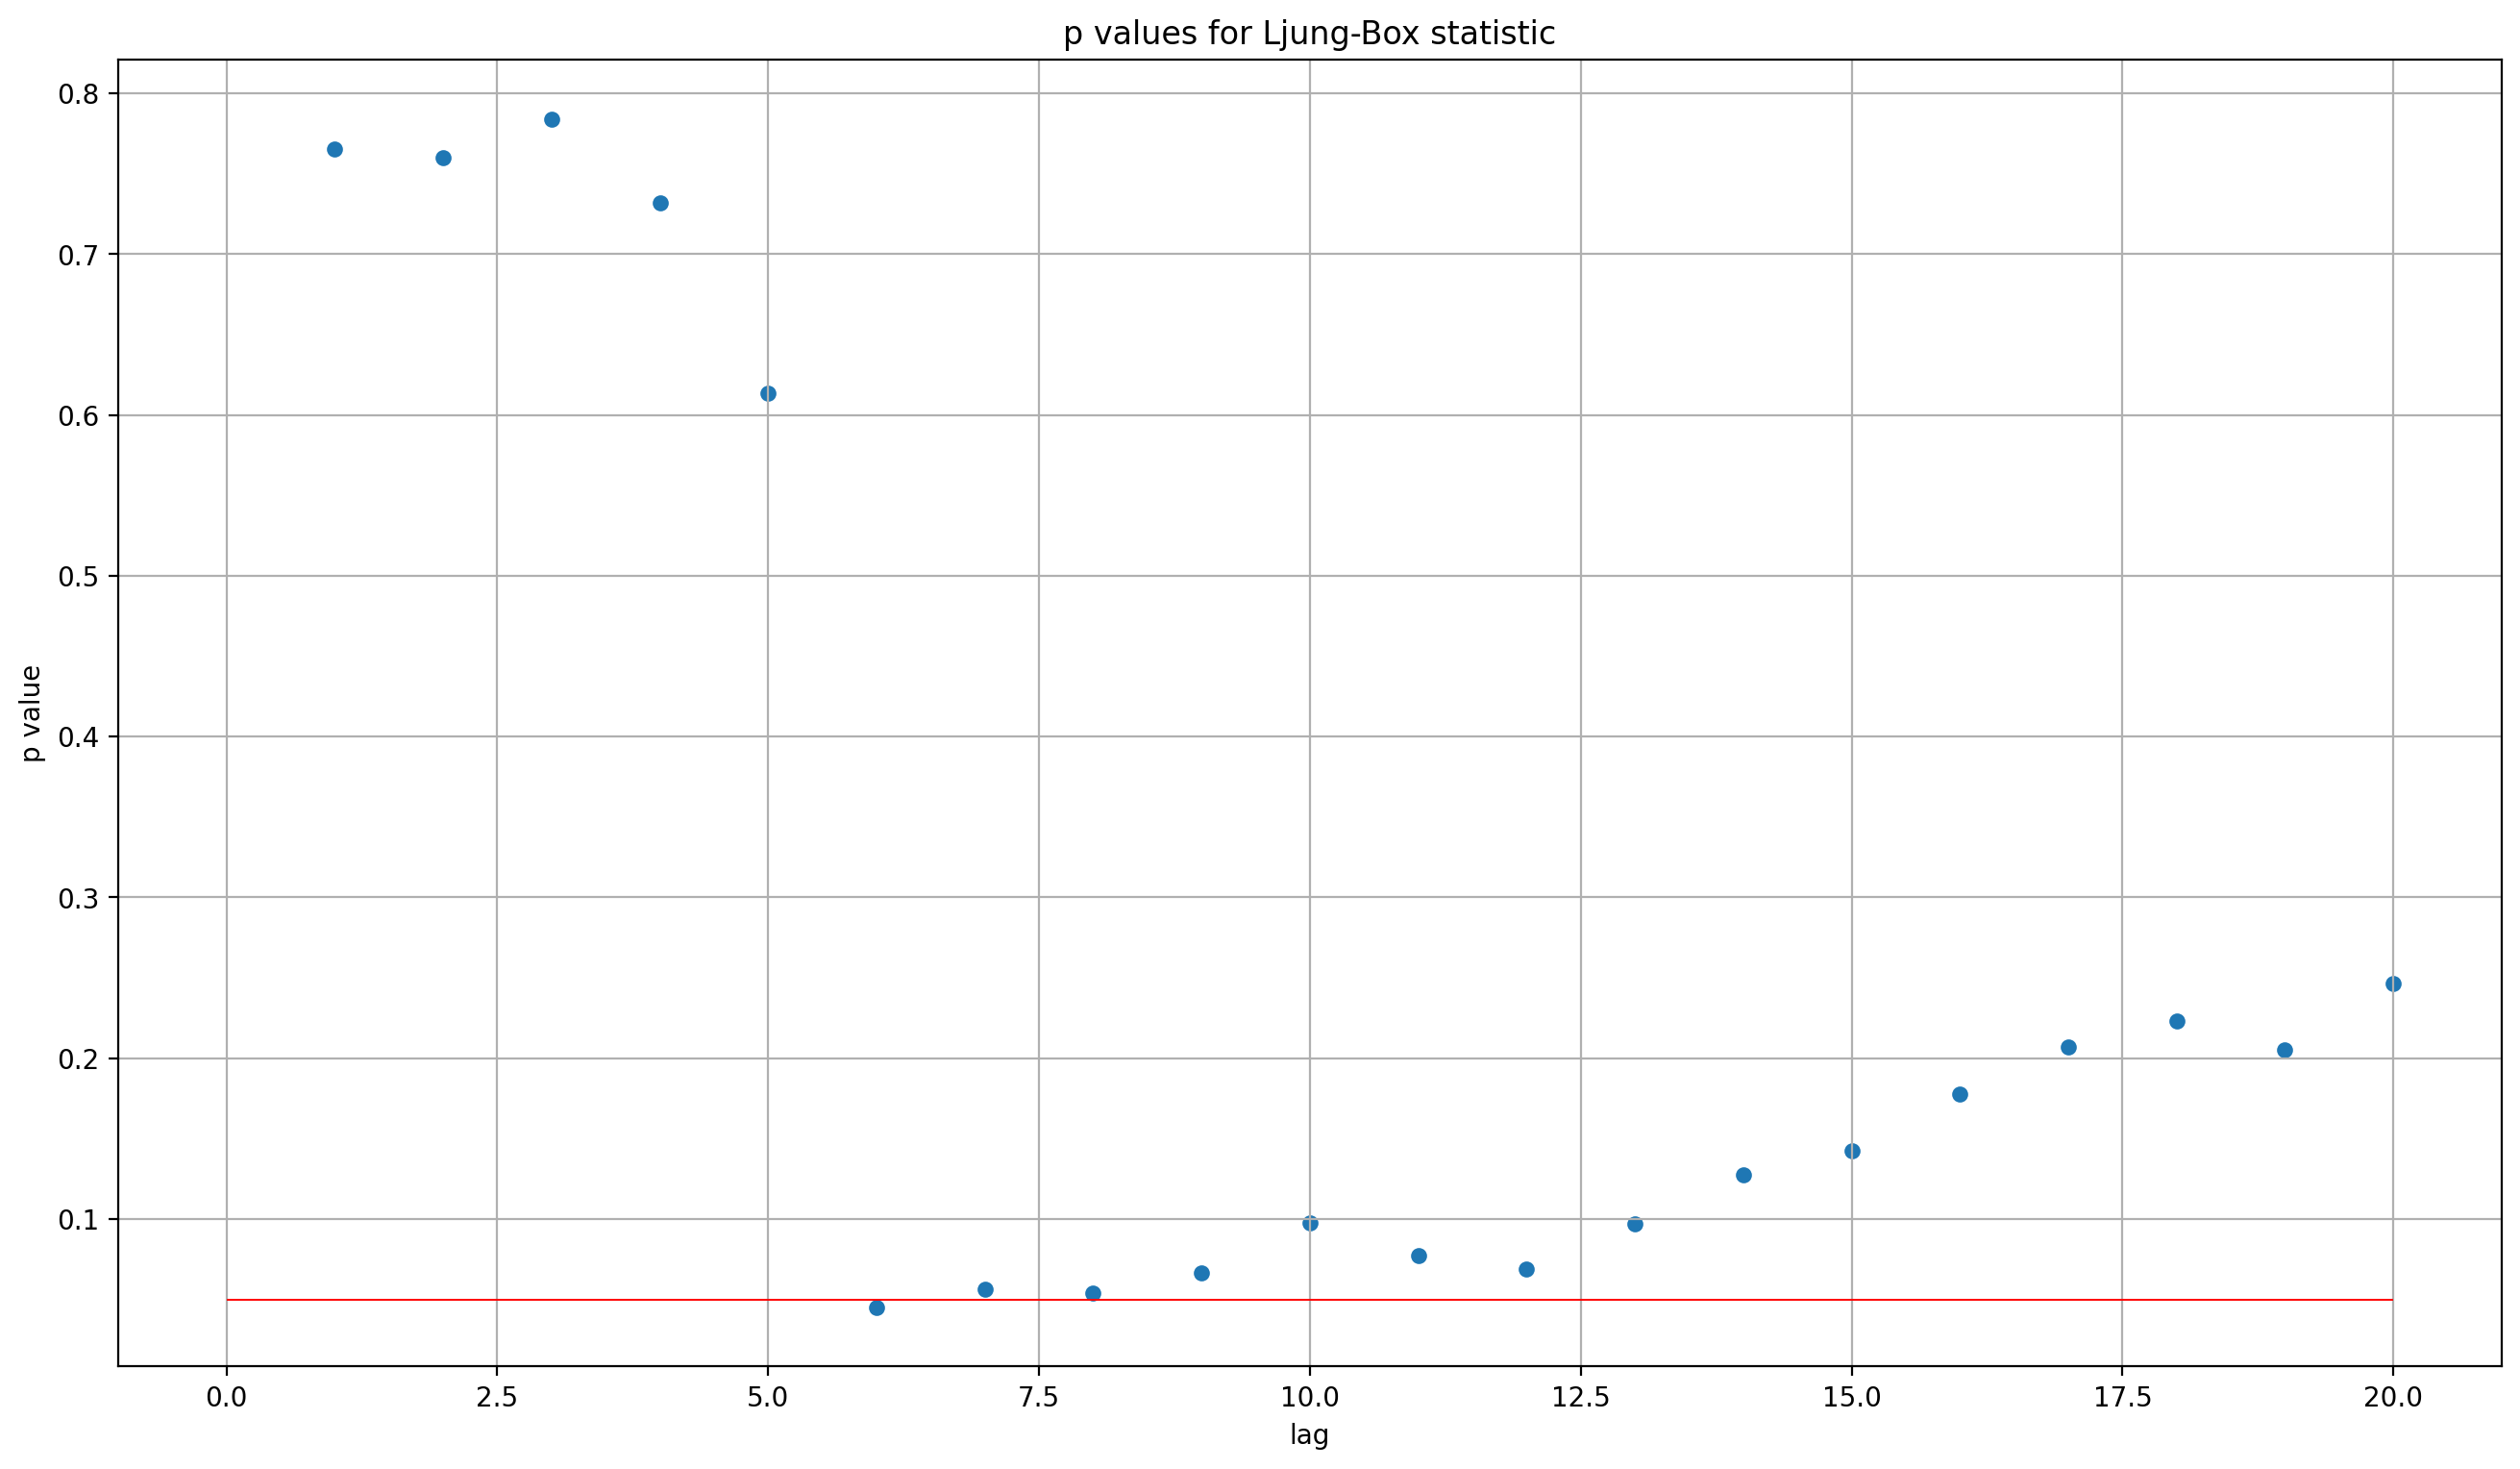

In [22]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(list(range(1,21)), VARMA_fps_result_61_re.test_serial_correlation(method="ljungbox", lags=20)[2, 1, :], s=25)
plt.hlines(y=[0.05], xmin=0, xmax=20, colors="r", linewidths=0.7)
# plt.axis([0, 20, 0, 1])
plt.title("p values for Ljung-Box statistic")
plt.xlabel("lag")
plt.ylabel("p value")
plt.grid()
plt.show()

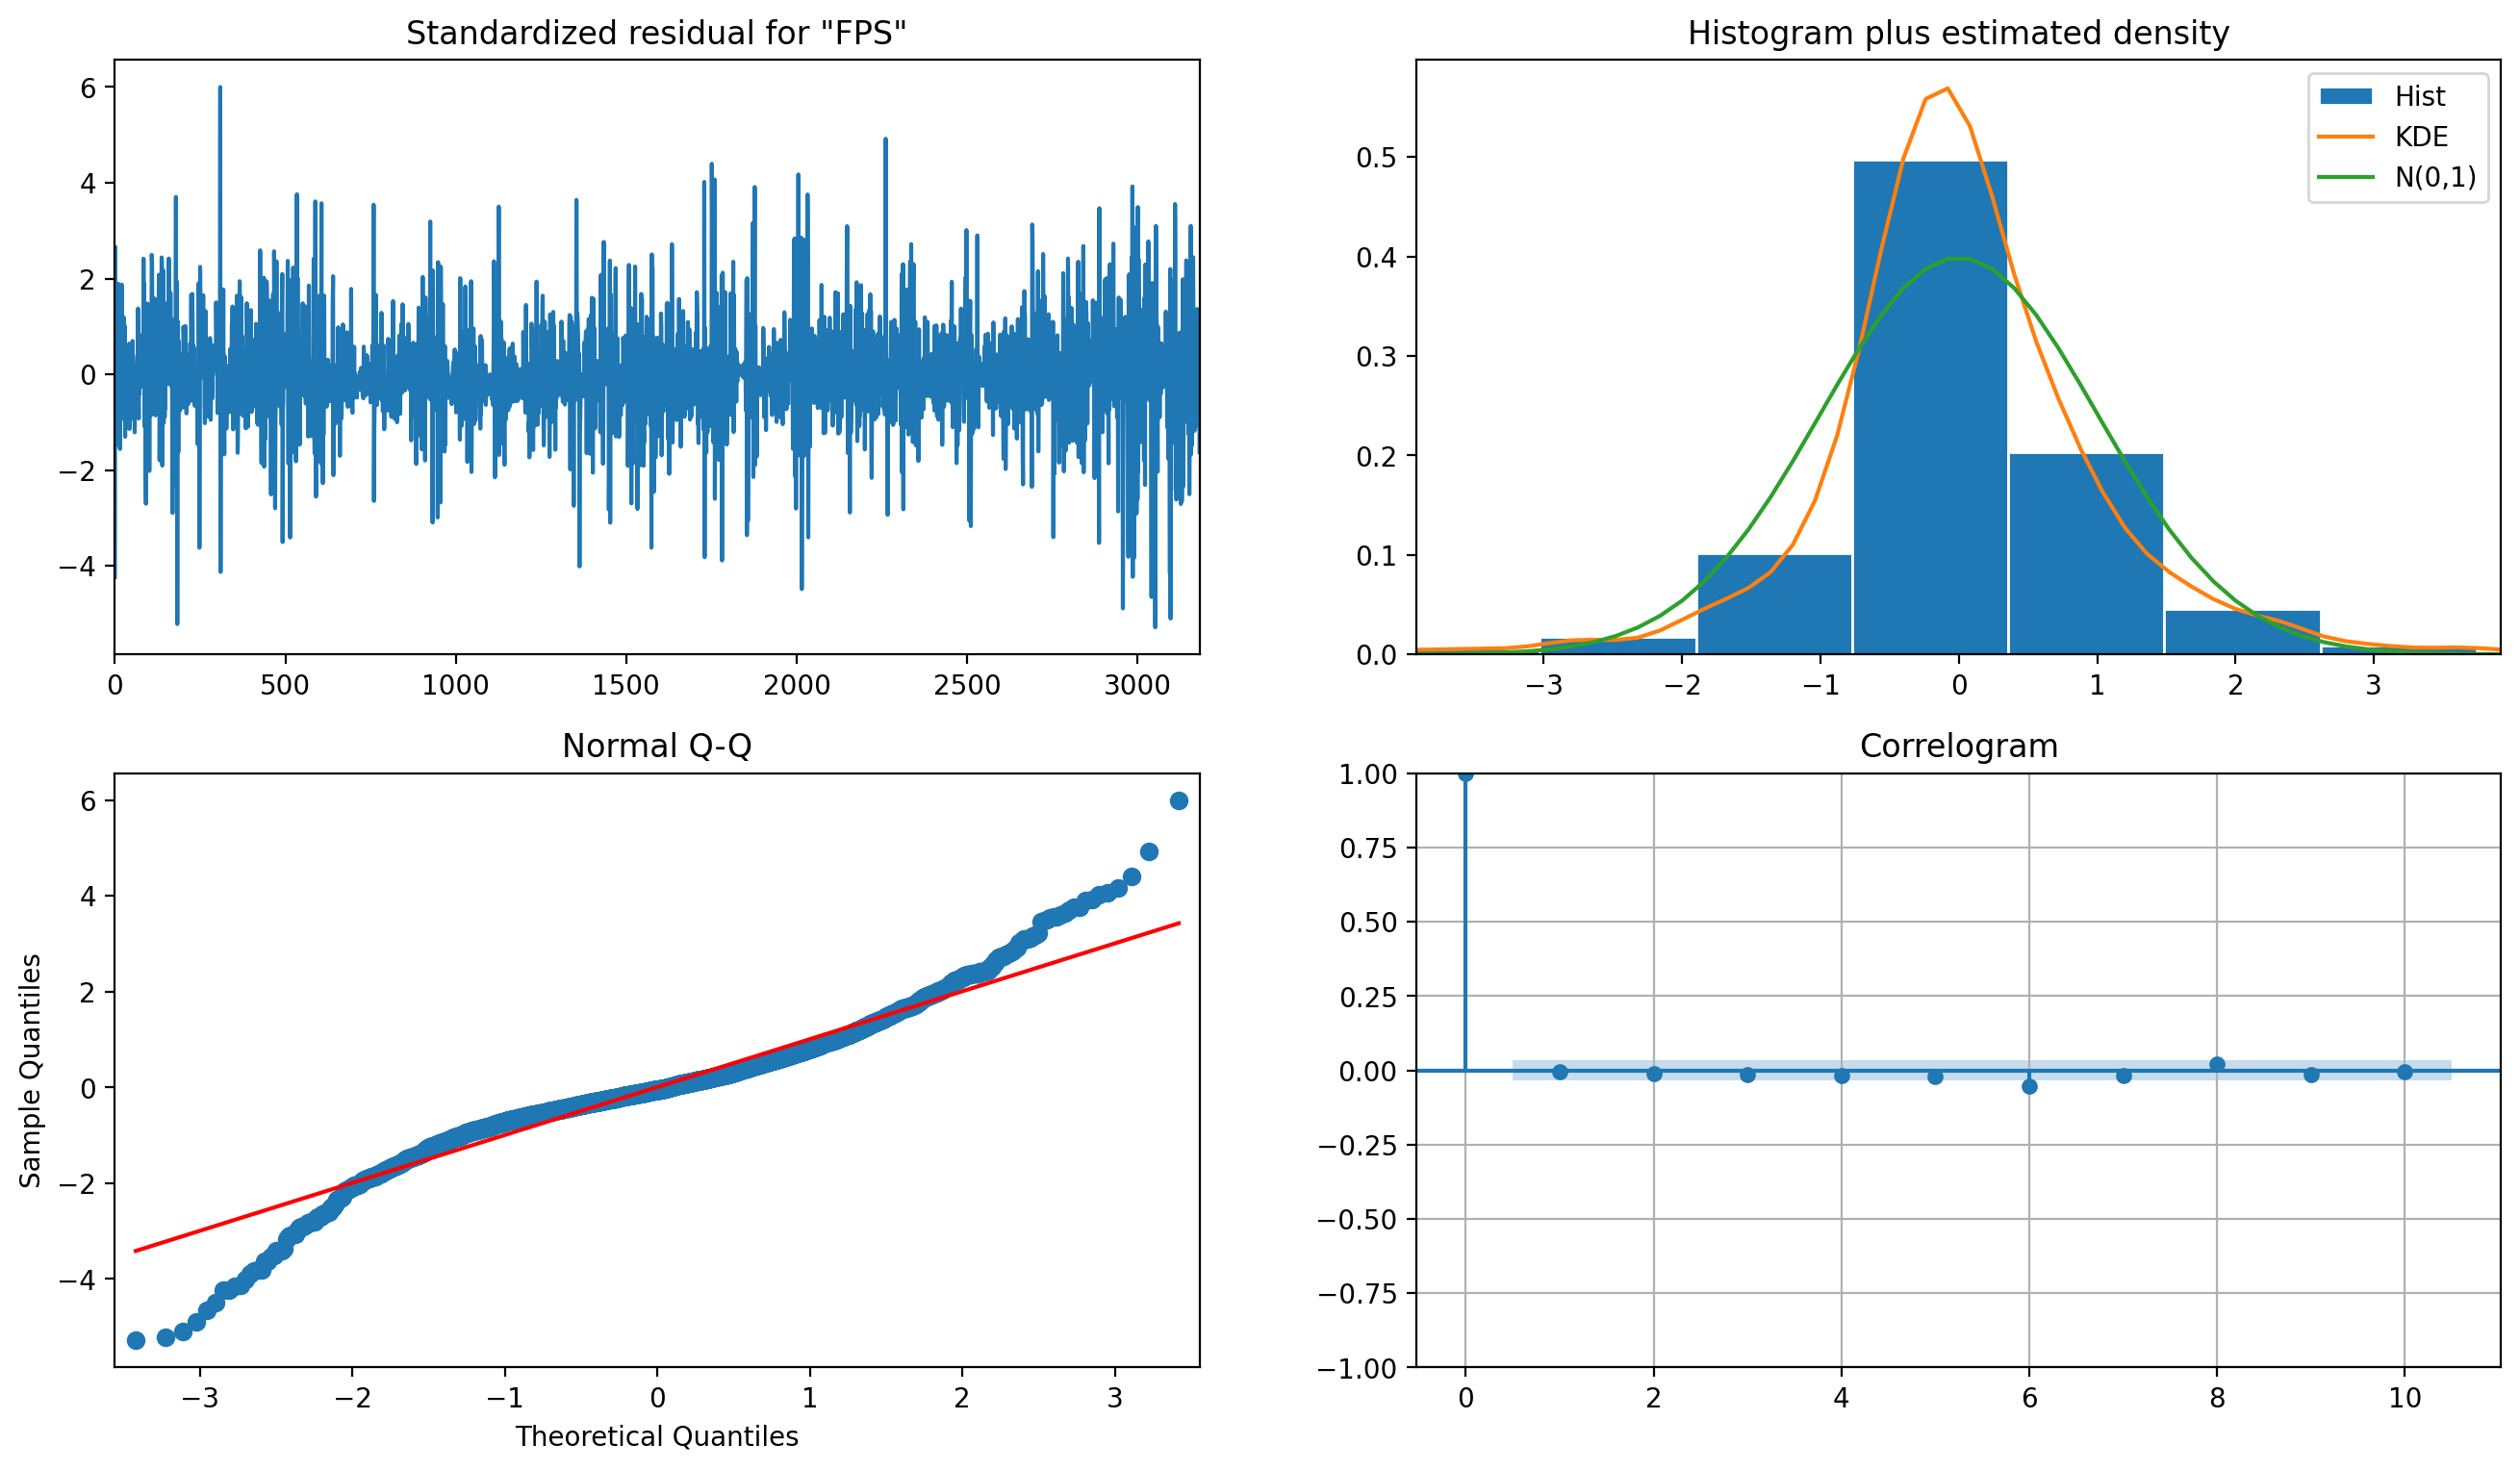

In [23]:
VARMA_fps_result_61_re.plot_diagnostics(variable=2, fig=plt.figure(figsize=(16,9), dpi=200))
plt.grid()
plt.show()

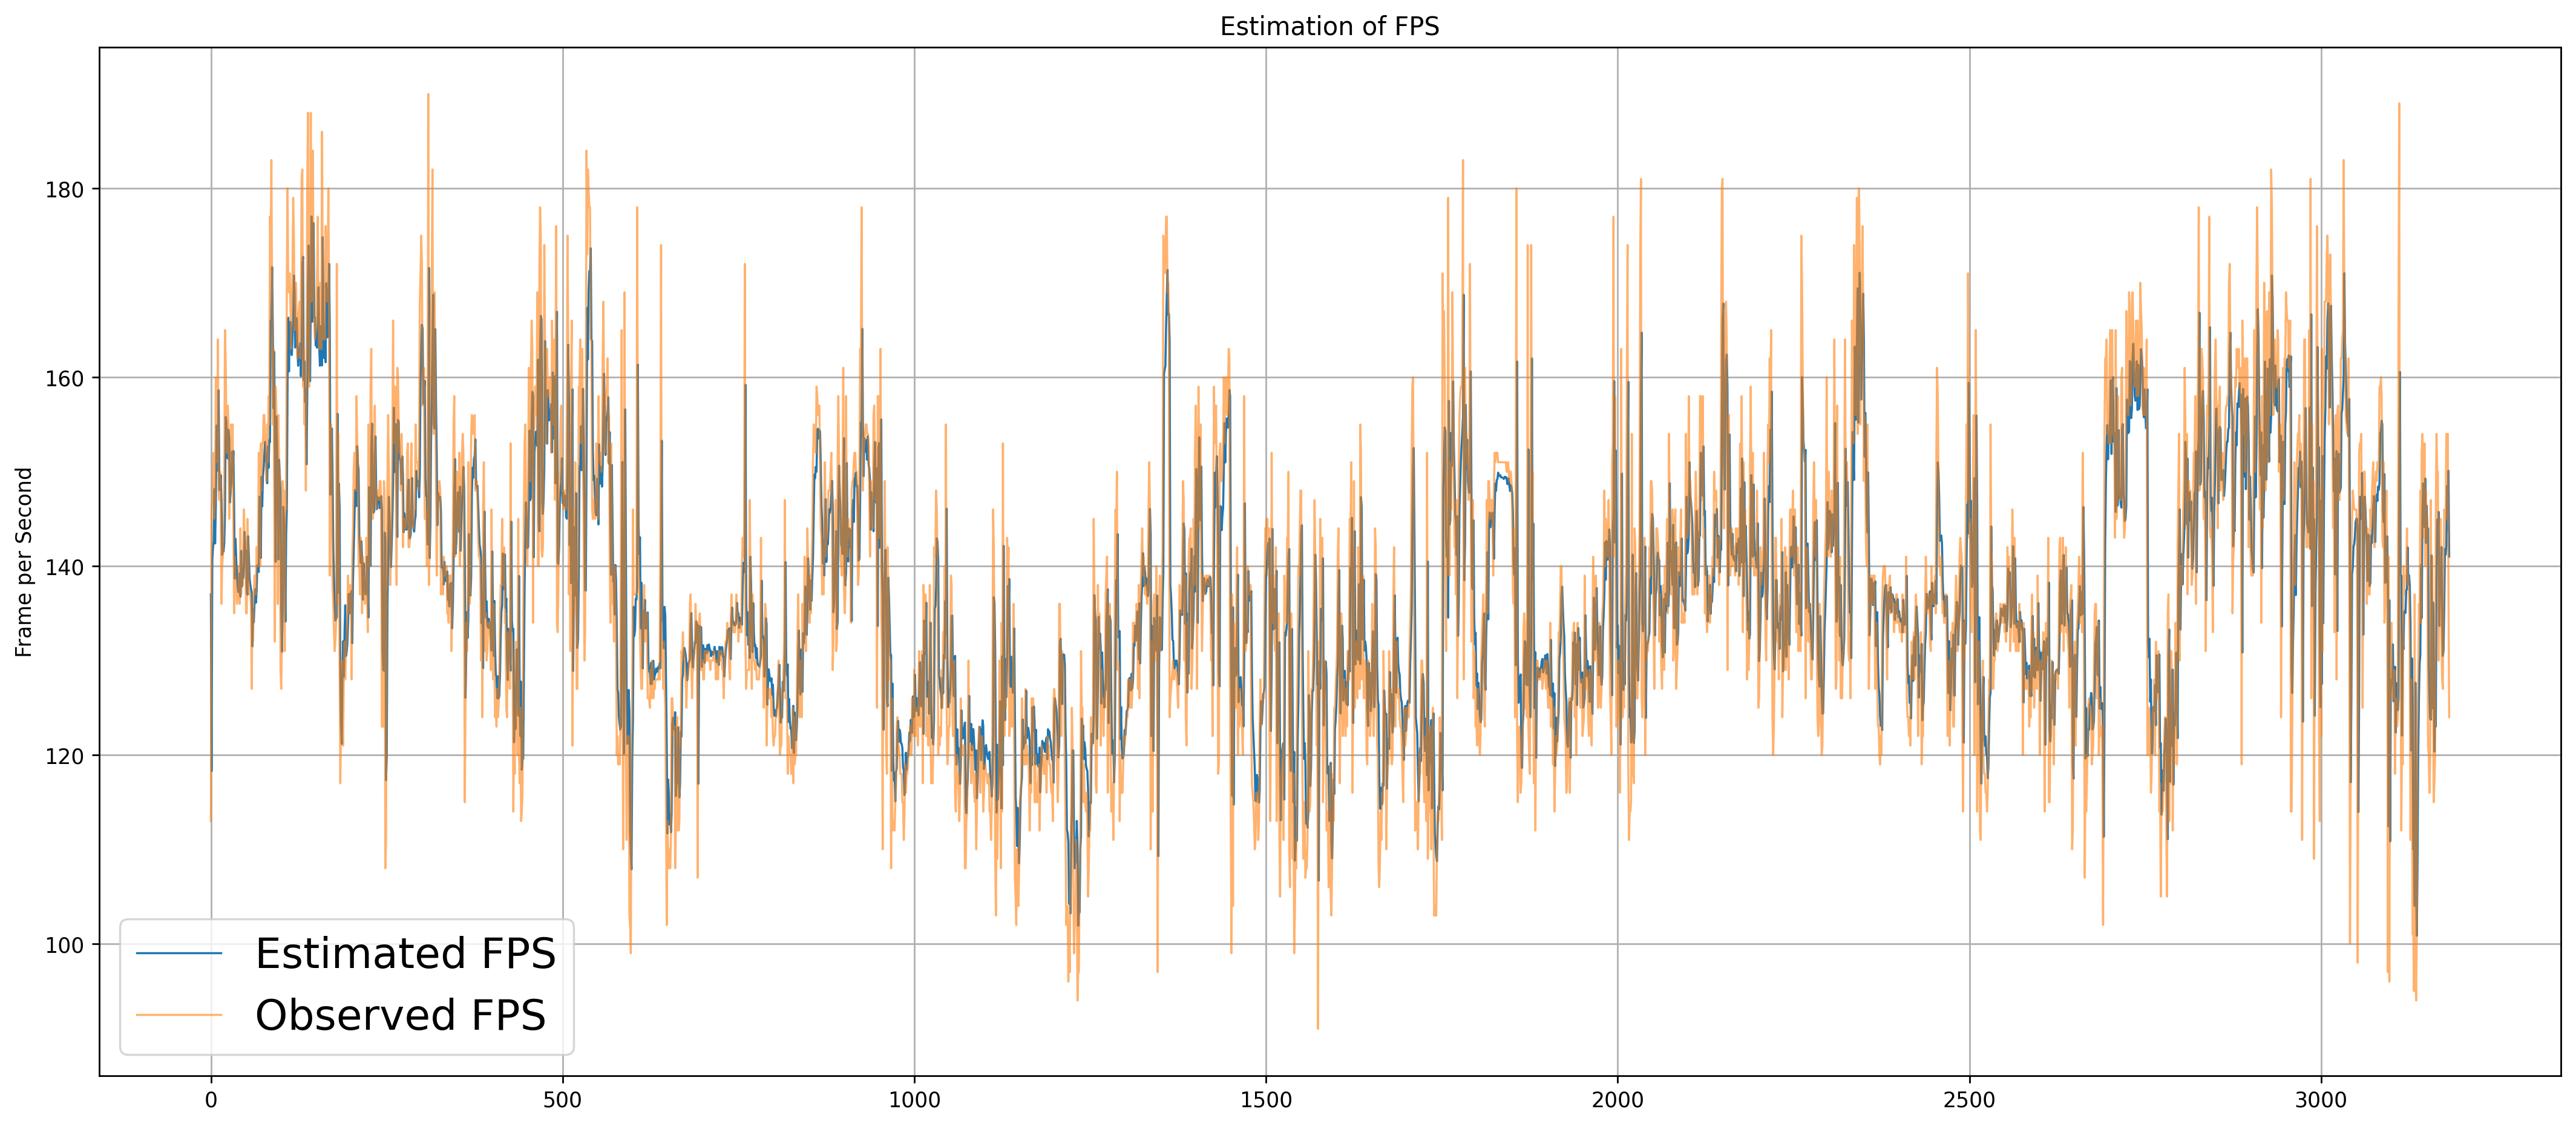

In [24]:
hat_FPS = VARMA_fps_result_61_re.predict().to_numpy()[:, 2]
plt.figure(figsize=(21, 9), dpi=250)
ts1, = plt.plot(hat_FPS, linewidth=1, label="Estimated FPS", c='tab:blue')
ts2, = plt.plot(horizon_train["FPS"], linewidth=1, label="Observed FPS", c='tab:orange', alpha=0.6)
plt.legend(handles=[ts1, ts2], fontsize=20)
plt.title("Estimation of FPS")
plt.ylabel("Frame per Second")
plt.grid()
plt.show()

In [25]:
varmax_forecasting_re = VARMA_fps_result_61_re.get_forecast(steps=300)

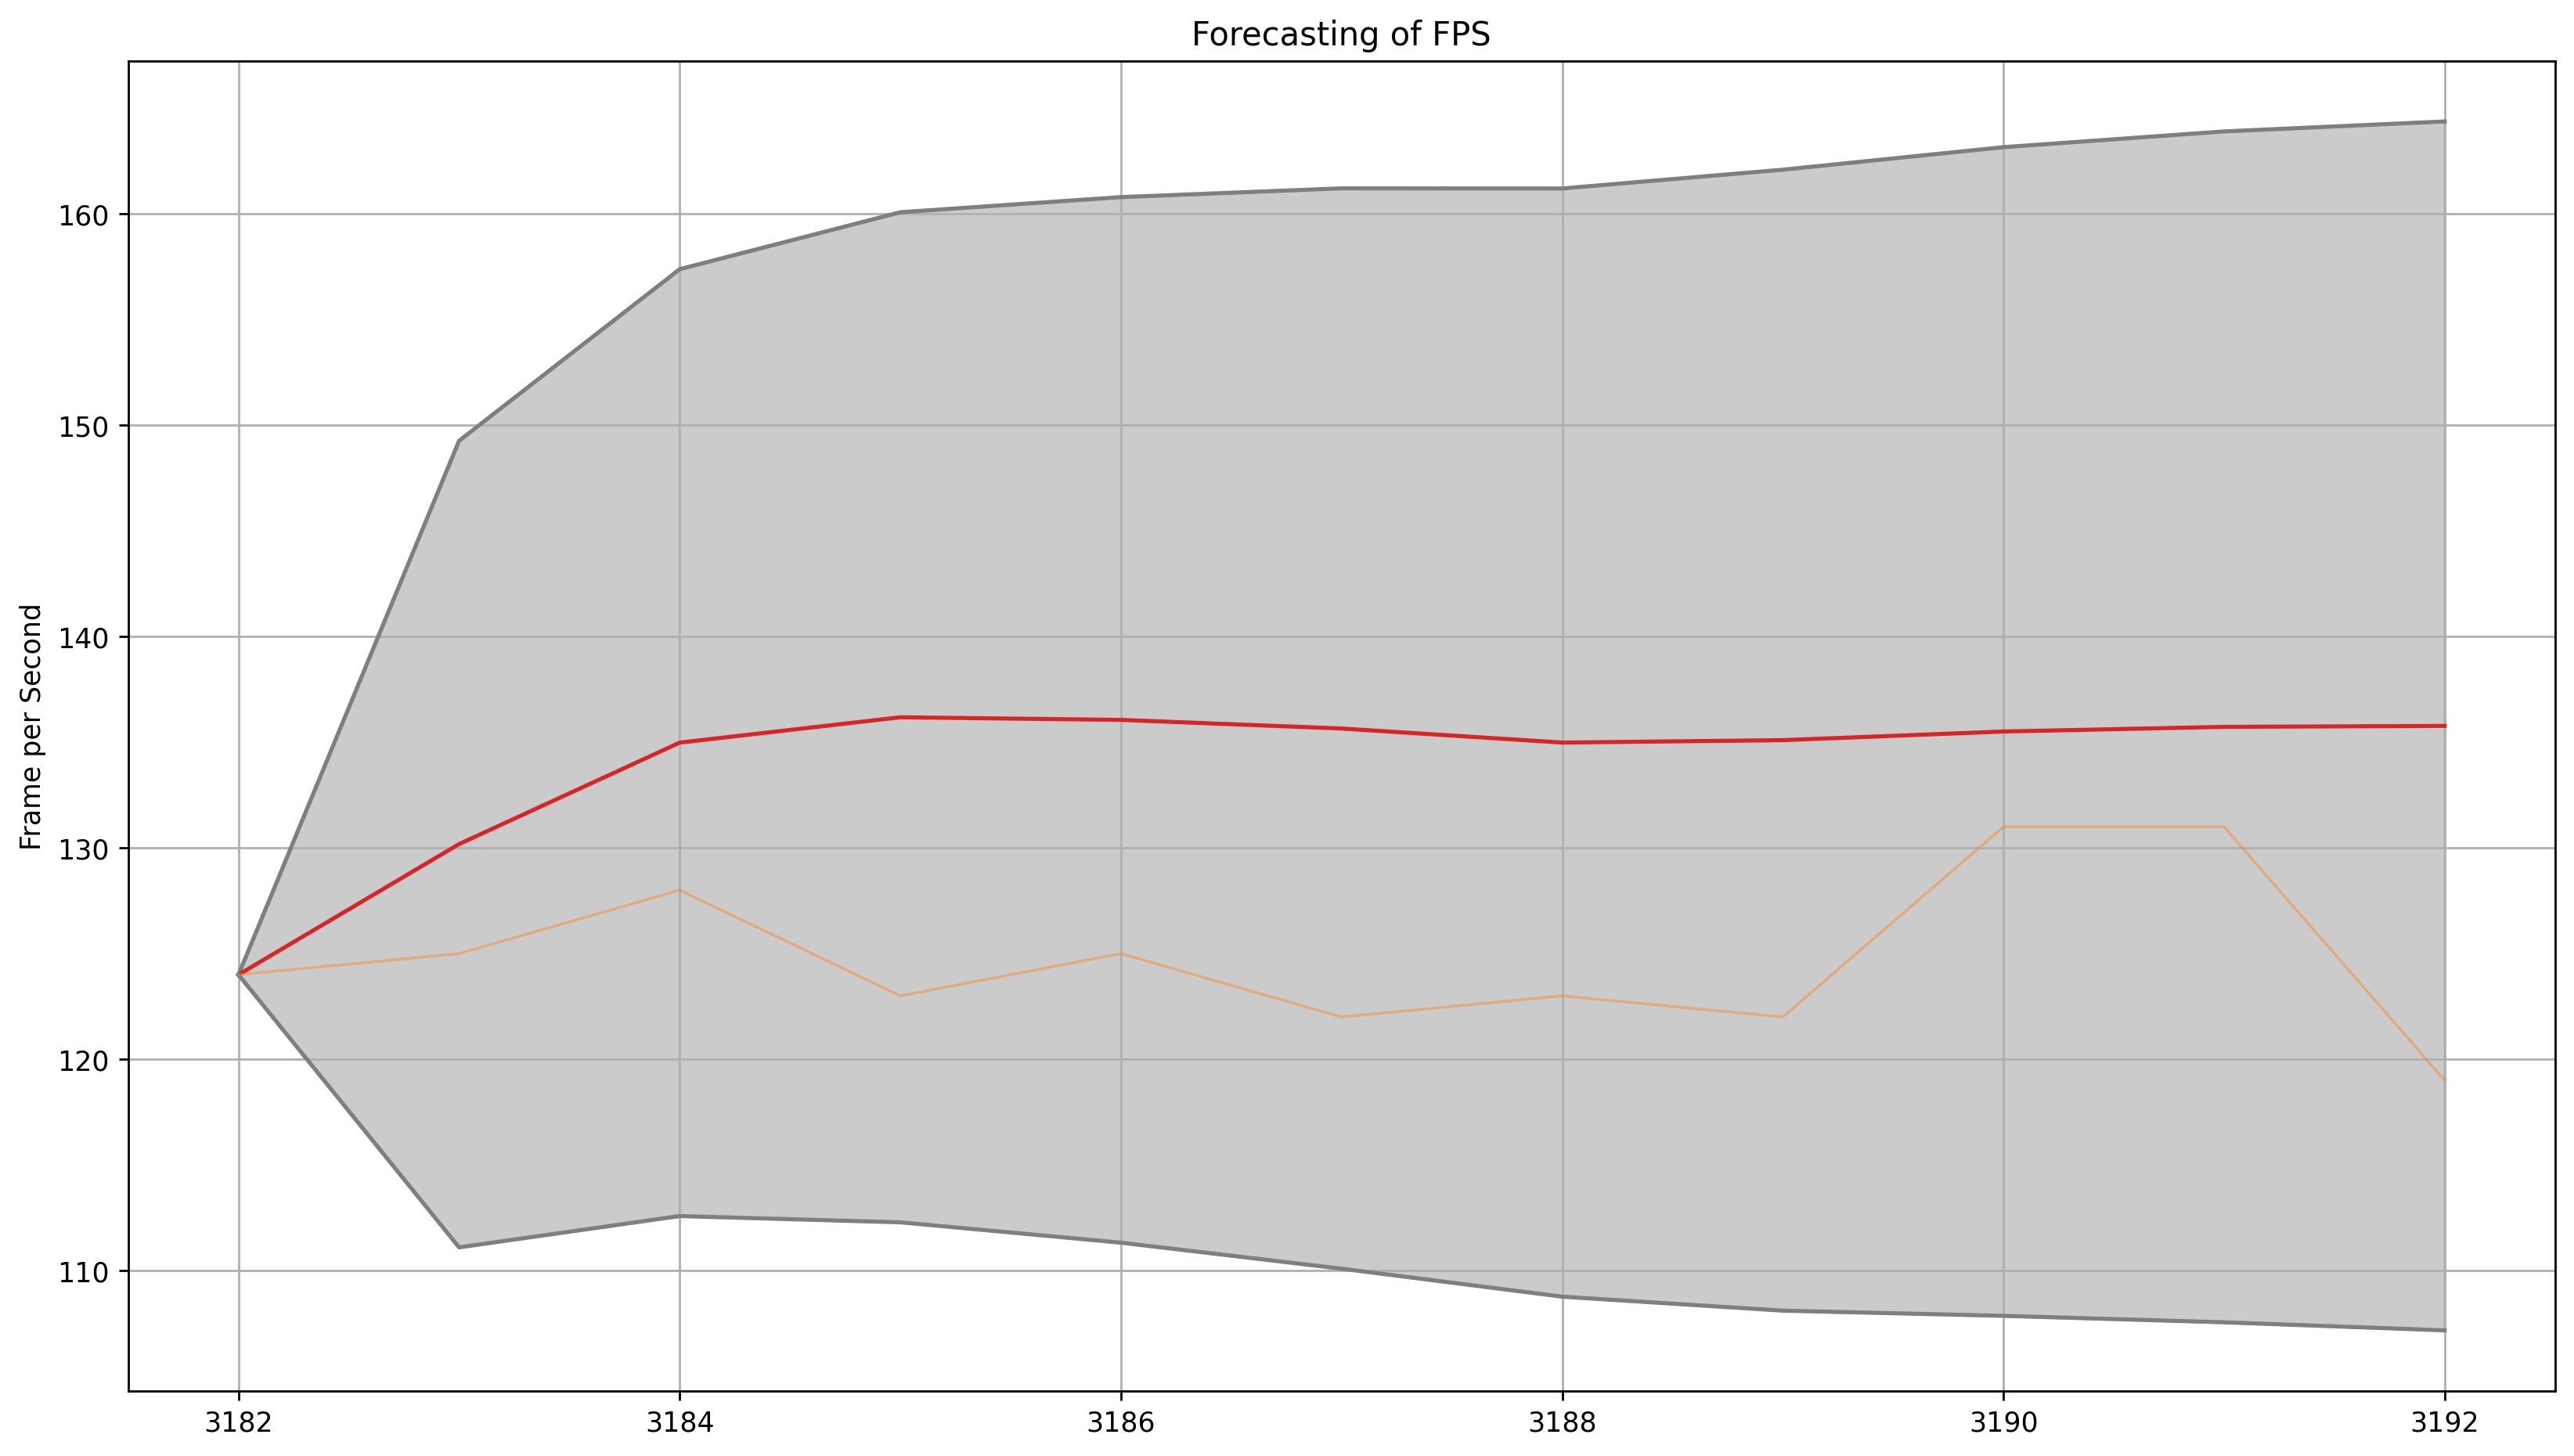

In [26]:
plt.figure(figsize=(16, 9), dpi=250)
plt.plot(list(range(3182, 3193)), upper:=pd.concat([horizon_train["FPS"], varmax_forecasting_re.conf_int()["upper FPS"]]).iloc[3182:3193], c='tab:gray')
plt.plot(list(range(3182, 3193)), pd.concat([horizon_train["FPS"], varmax_forecasting_re.predicted_mean["FPS"]]).iloc[3182:3193], c='tab:red')
plt.plot(list(range(3182, 3193)), lower:=pd.concat([horizon_train["FPS"], varmax_forecasting_re.conf_int()["lower FPS"]]).iloc[3182:3193], c='tab:gray')
plt.fill_between(list(range(3182, 3193)), upper, lower, color="tab:gray", alpha=0.4)
plt.plot(
    list(range(3182, 3193)), np.hstack((horizon_train["FPS"].to_numpy()[-1], horizon_test["FPS"].to_numpy())),
    linewidth=1, c='tab:orange', alpha=0.4
)
plt.title("Forecasting of FPS")
plt.ylabel("Frame per Second")
plt.grid()
plt.show()